In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def timeseries_bootstrap(tseries, block_size, seed=None):
    """
    Generates a bootstrap sample derived from the input time-series.
    Utilizes Circular-block-bootstrap method described in [1]_.

    Parameters
    ----------
    tseries : array_like
        A matrix of shapes (`M`, `N`) with `M` timepoints and `N` variables
    block_size : integer
        Size of the bootstrapped blocks
    random_state : integer
        the random state to seed the bootstrap

    Returns
    -------
    bseries : array_like
        Bootstrap sample of the input timeseries


    References
    ----------
    .. [1] P. Bellec; G. Marrelec; H. Benali, A bootstrap test to investigate
       changes in brain connectivity for functional MRI. Statistica Sinica,
       special issue on Statistical Challenges and Advances in Brain Science,
       2008, 18: 1253-1268.

    Examples
    --------

    >>> x = np.arange(50).reshape((5, 10)).T
    >>> sample_bootstrap(x, 3)
    array([[ 7, 17, 27, 37, 47 ],
           [ 8, 18, 28, 38, 48 ],
           [ 9, 19, 29, 39, 49 ],
           [ 4, 14, 24, 34, 44 ],
           [ 5, 15, 25, 35, 45 ],
           [ 6, 16, 26, 36, 46 ],
           [ 0, 10, 20, 30, 40 ],
           [ 1, 11, 21, 31, 41 ],
           [ 2, 12, 22, 32, 42 ],
           [ 4, 14, 24, 34, 44 ]])

    """
    import numpy as np

    if not seed:
        random_state = np.random.RandomState()
    else:
        random_state = np.random.RandomState(seed)

    # calculate number of blocks
    k = int(np.ceil(float(tseries.shape[0]) / block_size))

    # generate random indices of blocks
    r_ind = np.floor(random_state.rand(1, k) * tseries.shape[0])
    blocks = np.dot(np.arange(0, block_size)[:, np.newaxis], np.ones([1, k]))

    block_offsets = np.dot(np.ones([block_size, 1]), r_ind)
    block_mask = (blocks + block_offsets).flatten('F')[:tseries.shape[0]]
    block_mask = np.mod(block_mask, tseries.shape[0])

    #return tseries[block_mask.astype('int'), :], block_mask.astype('int')
    
    ################# modified the function to return vector of correlaiton matrix, instead of the time*parcel data.
    data=tseries[block_mask.astype('int'), :]
    data_corr=np.corrcoef(np.transpose(data))
    data_corr=upper_tri_indexing(data_corr)
    return data_corr


def timeseries_bootstrap_orig(tseries, block_size, seed=None):
    """
    Generates a bootstrap sample derived from the input time-series.
    Utilizes Circular-block-bootstrap method described in [1]_.

    Parameters
    ----------
    tseries : array_like
        A matrix of shapes (`M`, `N`) with `M` timepoints and `N` variables
    block_size : integer
        Size of the bootstrapped blocks
    random_state : integer
        the random state to seed the bootstrap

    Returns
    -------
    bseries : array_like
        Bootstrap sample of the input timeseries


    References
    ----------
    .. [1] P. Bellec; G. Marrelec; H. Benali, A bootstrap test to investigate
       changes in brain connectivity for functional MRI. Statistica Sinica,
       special issue on Statistical Challenges and Advances in Brain Science,
       2008, 18: 1253-1268.

    Examples
    --------

    >>> x = np.arange(50).reshape((5, 10)).T
    >>> sample_bootstrap(x, 3)
    array([[ 7, 17, 27, 37, 47 ],
           [ 8, 18, 28, 38, 48 ],
           [ 9, 19, 29, 39, 49 ],
           [ 4, 14, 24, 34, 44 ],
           [ 5, 15, 25, 35, 45 ],
           [ 6, 16, 26, 36, 46 ],
           [ 0, 10, 20, 30, 40 ],
           [ 1, 11, 21, 31, 41 ],
           [ 2, 12, 22, 32, 42 ],
           [ 4, 14, 24, 34, 44 ]])

    """
    import numpy as np

    if not seed:
        random_state = np.random.RandomState()
    else:
        random_state = np.random.RandomState(seed)

    # calculate number of blocks
    k = int(np.ceil(float(tseries.shape[0]) / block_size))

    # generate random indices of blocks
    r_ind = np.floor(random_state.rand(1, k) * tseries.shape[0])
    blocks = np.dot(np.arange(0, block_size)[:, np.newaxis], np.ones([1, k]))

    block_offsets = np.dot(np.ones([block_size, 1]), r_ind)
    block_mask = (blocks + block_offsets).flatten('F')[:tseries.shape[0]]
    block_mask = np.mod(block_mask, tseries.shape[0])

    return tseries[block_mask.astype('int'), :], block_mask.astype('int')
    


def upper_tri_indexing(A):
    m = A.shape[0]
    r,c = np.triu_indices(m,1)
    return A[r,c]

def vec2symMat(vect,n):
    mat=np.zeros(shape=(n,n))
    pre=0
    for i in range(0,n):
        mat[i,i]=1
        if i != (n-1):
            mat[i,(i+1):n] = vect[pre:(pre+n-i-1)]
            mat[(i+1):n,i] = vect[pre:(pre+n-i-1)]
            pre=(pre+n-i-1)
    return mat

0.1601877903833808


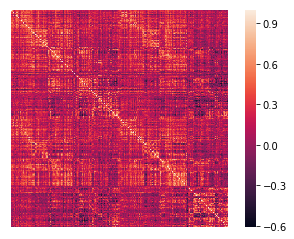

In [104]:
# Correlation matrix without Bagging
datain='209228_rfMRI_REST1_LR_Atlas_MSMAll_hp2000_clean_flt.10k.dtseries_TS_Parcel.txt'
data=np.loadtxt(datain,delimiter=',')
#data=data[0:400,:]

# correlaiton matrix without bagging:
data_corr=np.corrcoef(data.T)
#data_corr=upper_tri_indexing(data_corr)
sns.heatmap(data_corr,square=True,xticklabels='',yticklabels='')
print(np.mean(data_corr))
data1=upper_tri_indexing(data_corr)





0.15742768338103733


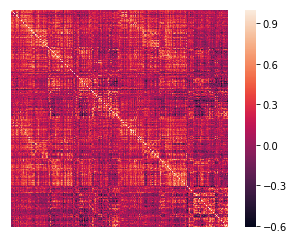

In [100]:
# Time series Bagging 500 times
block_size=np.int(np.floor(np.sqrt(data.shape[0]))) # for time series bootstrap

# find optimal 0.5 to 2 witth 0.25 steps. 
# 0.5, 0.8 1. 1.5 2. 
# similar 
# bagging improves the reproducibility. 

for i in range(0,500):
    if i ==0:
        tmp = timeseries_bootstrap(data, block_size)
    else:
        tmp = tmp + timeseries_bootstrap(data, block_size)

data_ts=tmp/float(500)
data_ts_corr=vec2symMat(data_ts,998)

sns.heatmap(data_ts_corr,square=True,xticklabels='',yticklabels='')
print(np.mean(data_ts_corr))



Text(0,0.5,'No Bagging')

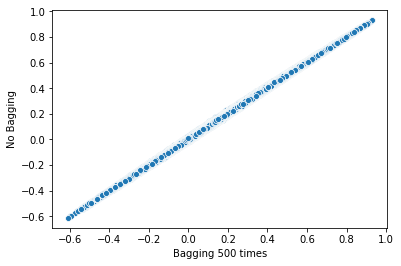

In [40]:
#fig=plt.plot(figsize=(2,6))
np.corrcoef(upper_tri_indexing(data_ts_corr),upper_tri_indexing(data_corr))
sns.scatterplot(upper_tri_indexing(data_ts_corr),upper_tri_indexing(data_corr))
plt.xlabel('Bagging 500 times')
plt.ylabel('No Bagging')



Text(0,0.5,'No Bagging')

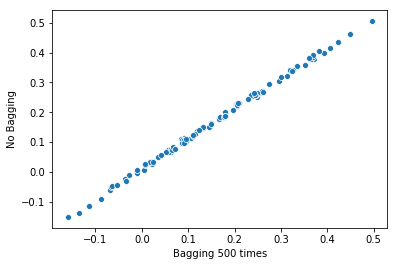

In [41]:
# zoom in part of it.
sns.scatterplot(upper_tri_indexing(data_ts_corr)[1:100],upper_tri_indexing(data_corr)[1:100])
plt.xlabel('Bagging 500 times')
plt.ylabel('No Bagging')

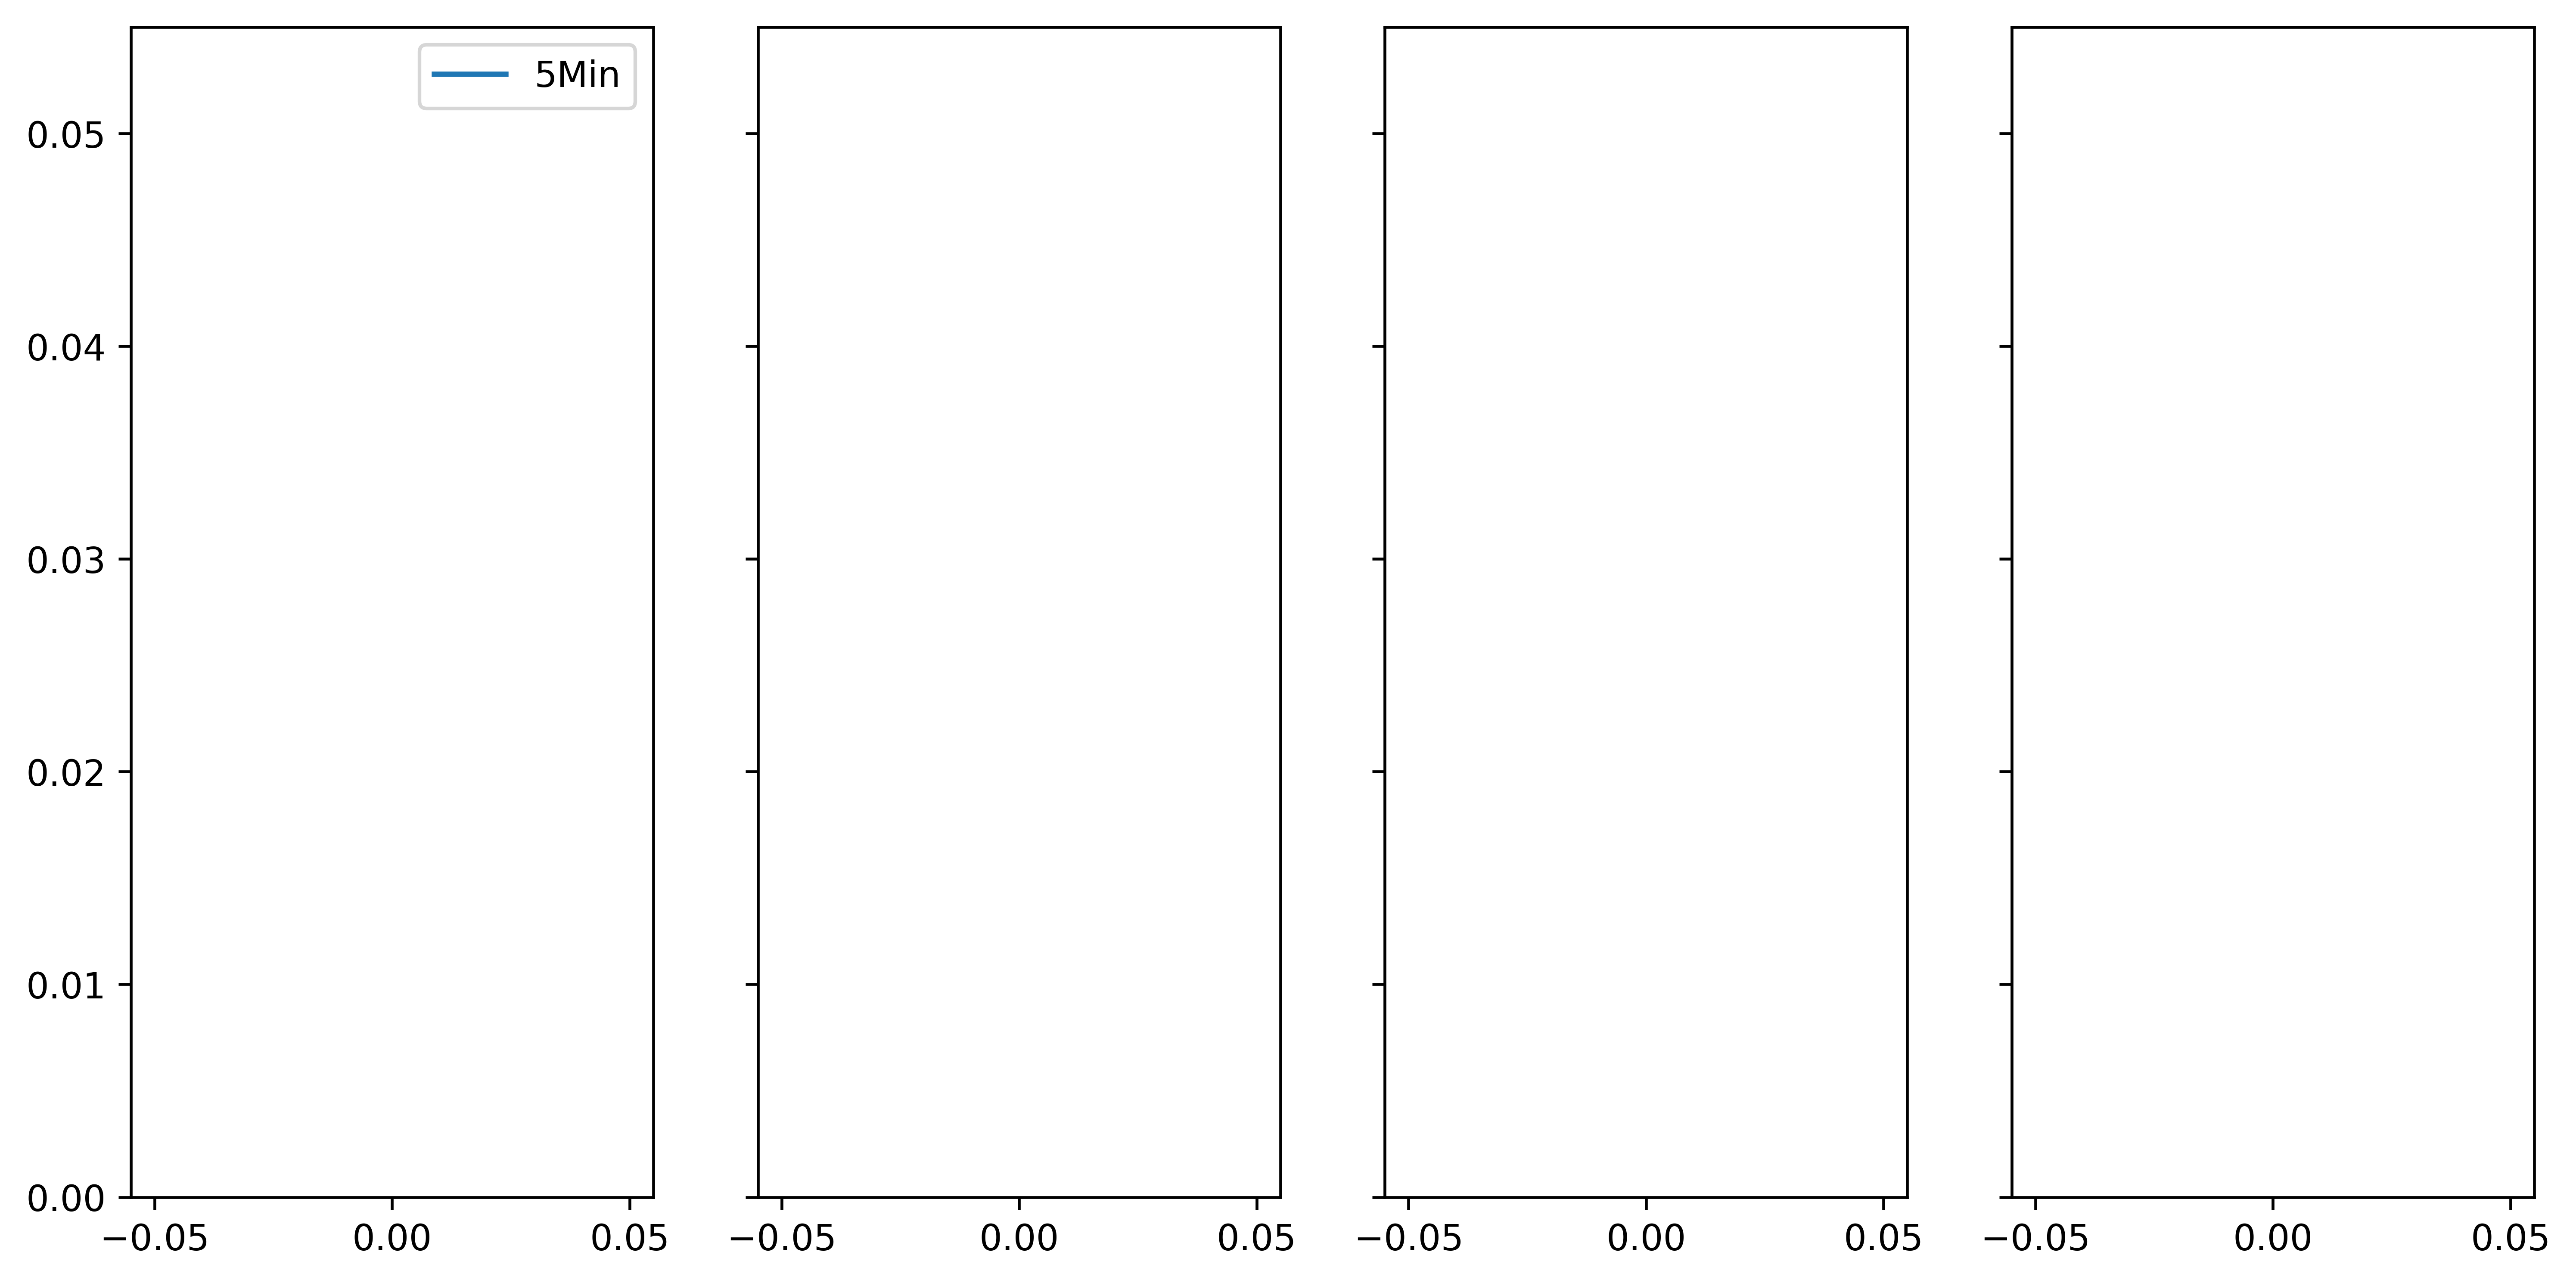

In [20]:
# Correlattion or euclidean distance between with and without bagging for all scan duration
import random
import pandas as pd
#df = pd.DataFrame(columns=['Base-5-10','Base-5-30','Base-5-60','Base-10-30','Base-10-60','Base-30-60','Base-5-10','BS-5-30','BS-5-60','BS-10-30','BS-10-60','BS-30-60'])
totalindex=0
timeduration='5'
num_edges=1000

#data1=np.reshape(data1,(1,len(data1)))
#data2=np.reshape(data2,(1,len(data2)))

# randome select the number of edge for correlation 100 times
corr_all=np.zeros((data1.shape[0],num_edges))
for rs in range(0,num_edges):
    start_idx=random.randint(0,(data1.shape[1]-num_edges-1))
    #print(start_idx)
    data1_tmp=data1[:,start_idx:(start_idx+num_edges)]
    data2_tmp=data2[:,start_idx:(start_idx+num_edges)]
    # loop through subjects
    corr_tmp=[]
    for i in range(0,data1.shape[0]):
        corr_all[i,rs]=np.corrcoef(data1_tmp[i,:],data2_tmp[i,:])[0,1]

corr_tmp=np.mean(corr_all,axis=1)
if totalindex==0:
    df = pd.DataFrame(corr_tmp, columns = [timeduration + 'Min']) 
else:
    tmp=pd.DataFrame(corr_tmp, columns = [timeduration + 'Min']) 
    df=pd.concat([df,tmp],axis=1)
totalindex += 1



# plot
fig, axs = plt.subplots(1,4,figsize=(12,6),sharex=True,sharey='row',dpi=600)
#plt.xlim([20,36])
#plt.ylim([20,36])

totalindex=0
timeduration='5'
sns.kdeplot(df[timeduration+'Min'],ax=axs[totalindex])
totalindex += 1


## Plot time series.

(1190, 998)
(1190, 998)
[[1.         0.78062622]
 [0.78062622 1.        ]]


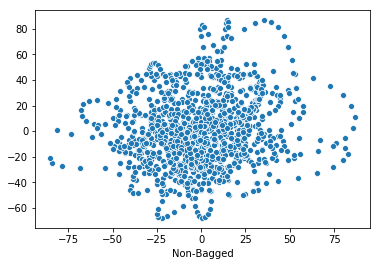

In [92]:
# Correlation matrix without Bagging
datain='209228_rfMRI_REST1_LR_Atlas_MSMAll_hp2000_clean_flt.10k.dtseries_TS_Parcel.txt'
# original data
data=np.loadtxt(datain,delimiter=',')
data_corr=np.corrcoef(np.transpose(data))
data_corr=upper_tri_indexing(data_corr)
    

# bagging
block_size=np.int(np.floor(np.sqrt(data.shape[0]))) # for time series bootstrap
data_bag,bag_index = timeseries_bootstrap_orig(data, block_size)
data_corr_bag=np.corrcoef(np.transpose(data_bag))
data_corr_bag=upper_tri_indexing(data_corr_bag)
    
    

print(data.shape)
print(data_bag.shape)

ii=50
sns.scatterplot(data[:,ii],data_bag[:,ii])
plt.xlabel('Bagged')
plt.xlabel('Non-Bagged')


print(np.corrcoef(data_bag[:,ii],data_bag[:,ii+1]))
#print(np.corrcoef(data[:,ii],data[:,ii+1]))

#print(np.corrcoef(data_corr_bag,data_corr))


0.15477109030987563


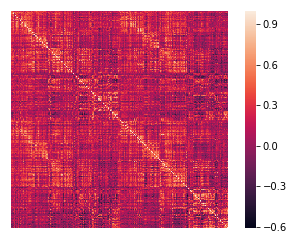

In [44]:
# Time series Bagging 500 times
block_size=np.int(np.floor(np.sqrt(data.shape[0]))) # for time series bootstrap

# find optimal 0.5 to 2 witth 0.25 steps. 
# 0.5, 0.8 1. 1.5 2. 
# similar 
# bagging improves the reproducibility. 

for i in range(0,500):
    if i ==0:
        tmp = timeseries_bootstrap(data, block_size, seed=i)
    else:
        tmp = tmp + timeseries_bootstrap(data, block_size, seed=i)

data_ts=tmp/float(500)
data_ts_corr=vec2symMat(data_ts,998)

#sns.heatmap(data_ts_corr,square=True,xticklabels='',yticklabels='')
data2=upper_tri_indexing(data_ts_corr)
print(np.mean(data_ts_corr))


0.1601877903833808
0.99957727796479


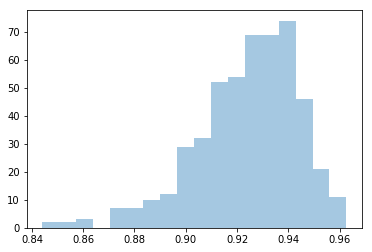

In [90]:
# Correlation matrix without Bagging
datain='209228_rfMRI_REST1_LR_Atlas_MSMAll_hp2000_clean_flt.10k.dtseries_TS_Parcel.txt'
data=np.loadtxt(datain,delimiter=',')
#data=data[0:400,:]

# correlaiton matrix without bagging:
data_corr=np.corrcoef(data.T)
#data_corr=upper_tri_indexing(data_corr)
#sns.heatmap(data_corr,square=True,xticklabels='',yticklabels='')
#print(np.mean(data_corr))
data1=upper_tri_indexing(data_corr)


# Time series Bagging 500 times
block_size=np.int(np.floor(np.sqrt(data.shape[0]))) # for time series bootstrap

# find optimal 0.5 to 2 witth 0.25 steps. 
# 0.5, 0.8 1. 1.5 2. 
# similar 
# bagging improves the reproducibility. 
corr_bag=[]
for i in range(0,500):
    data_ts = timeseries_bootstrap(data, block_size, seed=i)
    if i ==0:
        tmp = data_ts
    else:
        tmp = tmp + data_ts
    corr_bag.append(np.corrcoef(data1,data_ts)[0,1])
tmp = tmp/float(500)


sns.distplot(np.array(corr_bag),kde=False)

print(np.corrcoef(tmp,data1)[0,1])


# Does Bagging increase the similarity between different session of the data?

In [119]:
# Correlation matrix without Bagging
datain='209228_rfMRI_REST1_LR_Atlas_MSMAll_hp2000_clean_flt.10k.dtseries_TS_Parcel.txt'
data=np.loadtxt(datain,delimiter=',')
data_corr=np.corrcoef(data.T)
data1=upper_tri_indexing(data_corr)

datain='209228_rfMRI_REST2_LR_Atlas_MSMAll_hp2000_clean_flt.10k.dtseries_TS_Parcel.txt'
data=np.loadtxt(datain,delimiter=',')
data_corr=np.corrcoef(data.T)
data2=upper_tri_indexing(data_corr)

print(np.corrcoef(data1,data2))

[[1.         0.63554666]
 [0.63554666 1.        ]]


In [120]:
datain='209228_rfMRI_REST1_LR_Atlas_MSMAll_hp2000_clean_flt.10k.dtseries_TS_Parcel.txt'
data=np.loadtxt(datain,delimiter=',')
block_size=np.int(np.floor(np.sqrt(data.shape[0]))) # for time series bootstrap
for i in range(0,500):
    if i ==0:
        #tmp = timeseries_bootstrap(data, block_size, seed=i)
        tmp = timeseries_bootstrap(data, block_size)

    else:
        #tmp = tmp + timeseries_bootstrap(data, block_size, seed=i)
        tmp = tmp + timeseries_bootstrap(data, block_size)

data1_ts=tmp/float(500)

datain='209228_rfMRI_REST2_LR_Atlas_MSMAll_hp2000_clean_flt.10k.dtseries_TS_Parcel.txt'
data=np.loadtxt(datain,delimiter=',')
block_size=np.int(np.floor(np.sqrt(data.shape[0]))) # for time series bootstrap
for i in range(0,500):
    if i ==0:
        #tmp = timeseries_bootstrap(data, block_size, seed=i)
        tmp = timeseries_bootstrap(data, block_size)

    else:
        #tmp = tmp + timeseries_bootstrap(data, block_size, seed=i)
        tmp = tmp + timeseries_bootstrap(data, block_size)
data2_ts=tmp/float(500)
print(np.corrcoef(data1_ts,data2_ts))

[[1.         0.63734622]
 [0.63734622 1.        ]]


# Time series plot

In [191]:
datain='209228_rfMRI_REST1_LR_Atlas_MSMAll_hp2000_clean_flt.10k.dtseries_TS_Parcel.txt'
data=np.loadtxt(datain,delimiter=',')
data=data[0:200,:]

block_size=np.int(np.floor(np.sqrt(data.shape[0]))) # for time series bootstrap
#block_size=50

data_ts,index = timeseries_bootstrap_orig(data, block_size,seed=36)



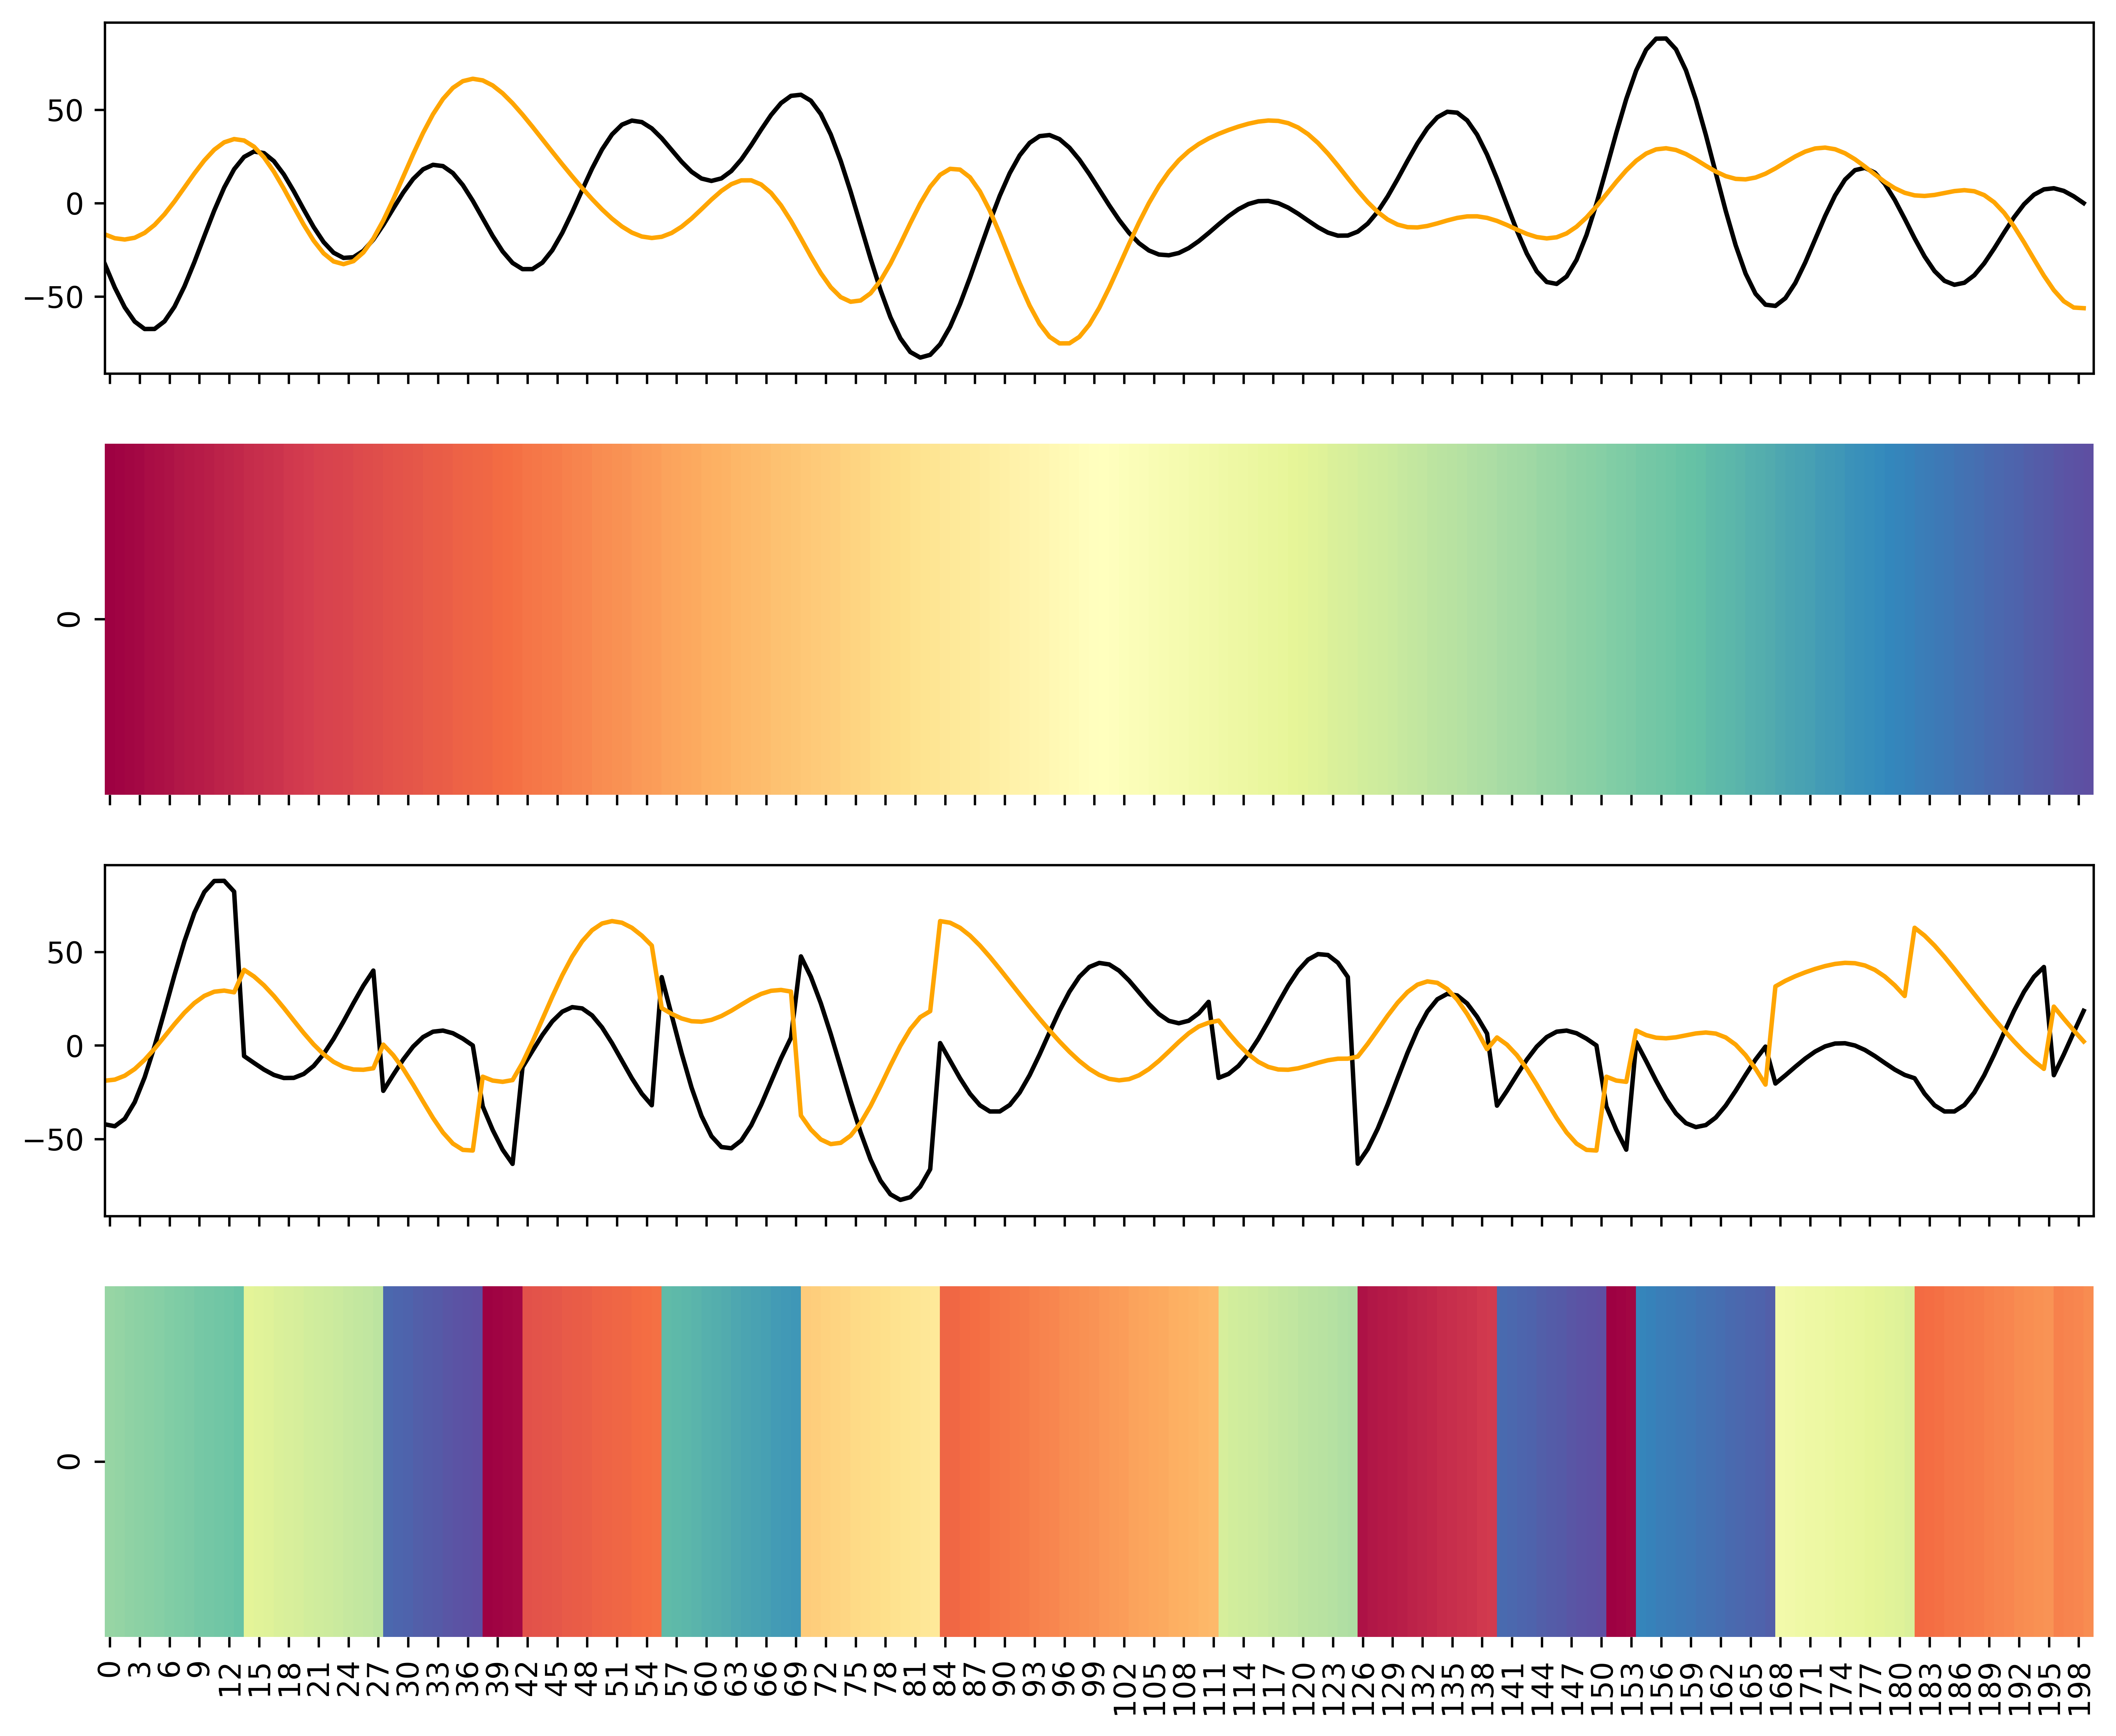

In [195]:
fig, axs = plt.subplots(4,1,figsize=(12,10),sharex=True,sharey='row',dpi=600)
#sns.heatmap(np.reshape(range(1,201),(1,200)),cmap="Spectral",ax=axs[1,0])
axs[0].plot(data[:,2],color='black')
axs[0].plot(data[:,534],color='orange')
sns.heatmap(np.reshape(range(1,201),(1,200)),cmap="Spectral",ax=axs[1],cbar=False)

# sns.scatterplot(predict,y_test,ax=axs[0,num_plot])

#sns.heatmap(np.reshape(range(1,201),(1,200)),cmap="Spectral",ax=axs[1,0])
axs[2].plot(data_ts[:,2],color='black')
axs[2].plot(data_ts[:,534],color='orange')

sns.heatmap(np.reshape(index,(1,200)),cmap="Spectral",ax=axs[3],cbar=False)

# sns.scatterplot(predict,y_test,ax=axs[0,num_plot])



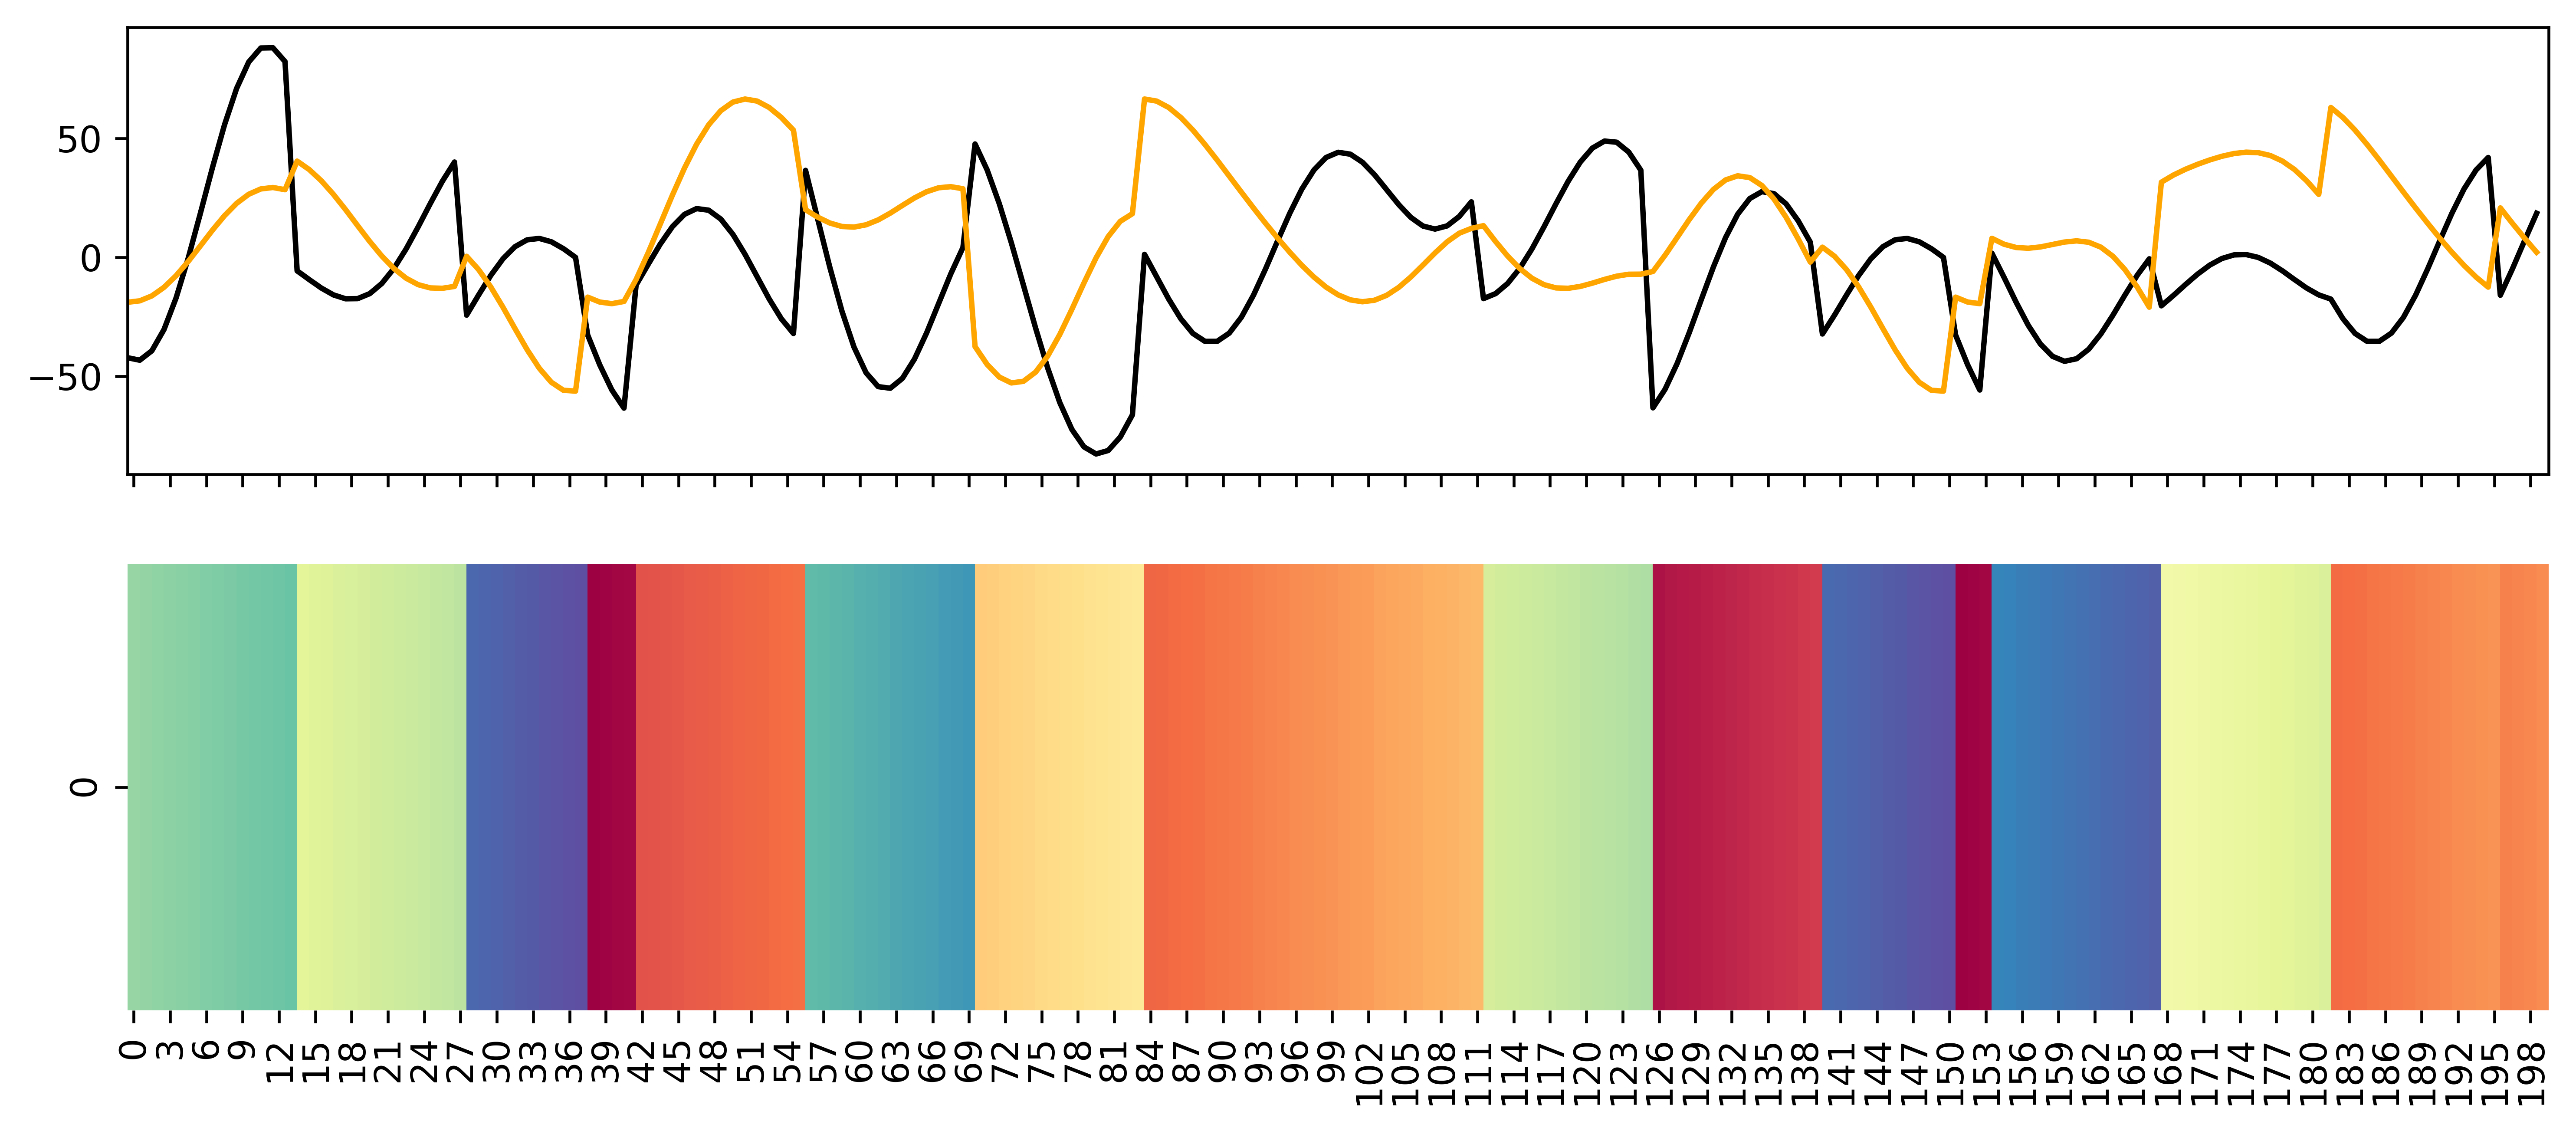

In [193]:
fig, axs = plt.subplots(2,1,figsize=(12,5),sharex=True,sharey='row',dpi=600)
#sns.heatmap(np.reshape(range(1,201),(1,200)),cmap="Spectral",ax=axs[1,0])
axs[0].plot(data_ts[:,2],color='black')
axs[0].plot(data_ts[:,534],color='orange')

sns.heatmap(np.reshape(index,(1,200)),cmap="Spectral",ax=axs[1],cbar=False)

# sns.scatterplot(predict,y_test,ax=axs[0,num_plot])


In [188]:
print(np.corrcoef(upper_tri_indexing(np.corrcoef(data_ts.T)),upper_tri_indexing(np.corrcoef(data.T))))

print(np.corrcoef(data_ts[:,534],data[:,534]))
print(np.corrcoef(data_ts[:,2],data[:,2]))

[[1.         0.85518668]
 [0.85518668 1.        ]]
[[ 1.         -0.10057306]
 [-0.10057306  1.        ]]
[[1.         0.19448405]
 [0.19448405 1.        ]]


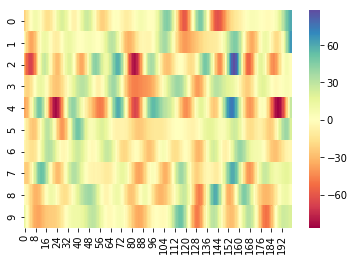

In [186]:
sns.heatmap(data.T[0:10,:],cmap="Spectral")
#sns.heatmap(data.T)
#print(data.T[0,:])

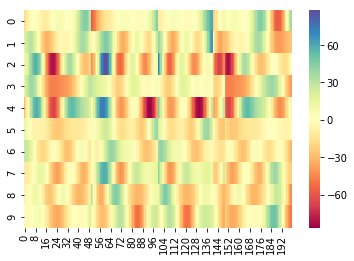

In [117]:
sns.heatmap(data_ts.T[0:10,:],cmap="Spectral")
#sns.heatmap(data_ts.T)

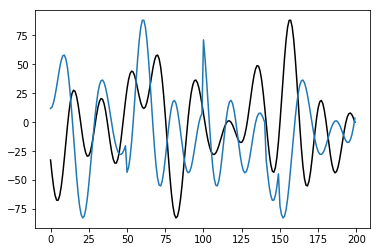

In [118]:
plt.plot(data[:,2],color='black')
plt.plot(data_ts[:,2])

In [83]:
data.shape

(200, 998)

In [55]:
k = int(np.ceil(float(data.shape[0]) / block_size))


In [54]:
k

4